In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import sys,time
import numpy as np
from scipy.constants import c,hbar
from scipy.interpolate import griddata

from synchrad.calc import SynchRad
from synchrad.utils import J_in_um

In [2]:
K0 = 0.1           # Undulator strength
Periods = 50       # Number of undulator periods
g0 = 100.          # Particle Lorentz factor
StepsPerPeriod=32  # Temporal resolution

gg = g0/(1.+K0**2/2)**.5
vb = (1.-gg**-2)**0.5
k_res = 2*gg**2
dt = 1./StepsPerPeriod
Steps2Do = int((Periods+2)/dt)+1

def uzFunctionUndulator(x):
    val = K0*np.sin(2*np.pi*x)
    val *= (x>0)*(x<1.5)*x/1.5 + (x>1.5)
    val *= (x>Periods-1.5)*(x<Periods)*(Periods-x)/1.5 + (x<Periods-1.5)
    return val

x = vb*np.r_[-1:Periods+1:Steps2Do*1j]
uz = uzFunctionUndulator(x-0.5*dt)
ux = (g0**2 - 1 - uz**2)**.5
z = uz[0]/g0*dt/2 + np.cumsum(uz/g0)*dt
y = np.zeros_like(x)
uy = np.zeros_like(x)
w = 1.0

particleTrack = [x, y, z, ux, uy, uz, w]

In [3]:
sr_in_far = {'Grid':[ (0.02*k_res,1.1*k_res),    # Wavenumber mapping region
                      (0,2./g0),                 # Elevation (theta) angle region
                      (0.,2*np.pi),              # Rotation (phi) angle
                      (400, 100, 32) ],          # Corresponding resolutions
             'TimeStep':dt,
             'ctx':[0, 2],
             'Features':(), }

calc = SynchRad(sr_in_far)

t0 = time.time()
calc.calculate_spectrum(particleTrack, comp='all')
print('Done farfield spectrum in {:g} sec'.format((time.time()-t0)))

energyModel = calc.get_energy(lambda0_um=1)
energyTheory = k_res*J_in_um*(7*np.pi/24)/137.*K0**2*(1+K0**2/2)*Periods
var = abs(energyModel - energyTheory)/energyTheory
print("Deviation from analytic estimate is {:.2f}%".format(var*100))

GPU DEVICE AMD Radeon R9 M370X Compute Engine IS CHOSEN ON Apple PLATFORM WITH OpenCL C 1.2  COMPILER
Done farfield spectrum in 13.2827 sec
Deviation from analytic estimate is 2.93%


<IPython.core.display.Javascript object>


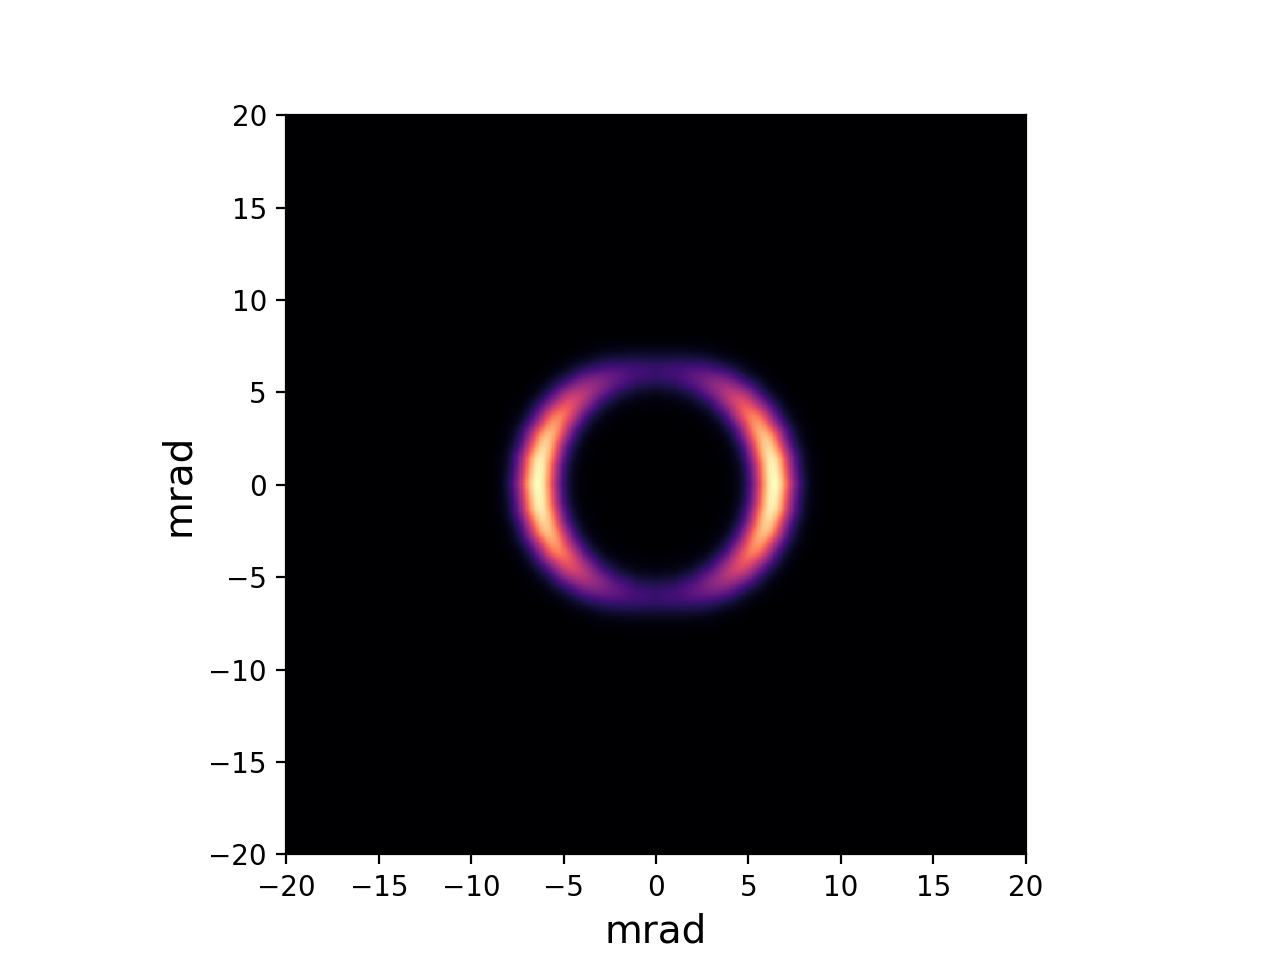

In [4]:
## Create exponential band-pass filter and plot the spot
kFilter = 0.7 * k_res
kBand = 0.1 * kFilter
k = calc.Args['omega'][:,None,None]
spect_filter = np.exp( -(k-kFilter)**2/kBand**2 ) 

spot, extent = calc.get_spot_cartesian( bins=(600,600), lambda0_um=1, 
                                     spect_filter=spect_filter )

plt.figure()
plt.imshow(spot, extent=extent*1e3, cmap=plt.cm.magma )
[ lab('mrad', size=14) for lab in (plt.xlabel, plt.ylabel) ];